# How to crawl bio.tools with its API ? 

This notebook shows you how to automate the crawling of biotools to filter or transform its content. Please send any comment or feedback to alban.gaignard@univ-nantes.fr. 

In [128]:
import urllib3
import requests
import json
import argparse
from argparse import RawTextHelpFormatter
from json.decoder import JSONDecodeError
import time
import sys, os
from rdflib import ConjunctiveGraph

# 1. Extending a JSON document with semantics (@context) -> JSON-LD

In [158]:
def rdfize(json_entry):
    """
    Transforms a biotools json entry into RDF, and returns a JSON-LD serialization. The following fields
    are covered: contact, publication, EDAM topic, EDAM operation, EDAM inputs & outputs.
    """

    entry = json_entry

    try:

        ctx = {
            "@context": {
                "@base": "https://bio.tools/",
                #"biotools": "https://bio.tools/ontology/",
                "edam": "http://edamontology.org/",
                #"pubmed": "https://www.ncbi.nlm.nih.gov/pubmed/",
                #"doi": "https://doi.org/",
                #"dc": "http://purl.org/dc/terms/",
                "rdfs": "http://www.w3.org/2000/01/rdf-schema#",
                
                "sc": "http://schema.org/", 
                "bsc": "http://bioschemas.org/",
                
                #"description": {'@id' : 'sc:description','@type' : 'xsd:string'},
                #"description": {'@id' : 'sc:description','@type' : 'sc:Text'},
                "description": 'sc:description',
                "name": "sc:name",
                "homepage": "sc:url",
                "toolType": 'sc:additionalType',
                "hasTopic": 'sc:applicationSubCategory',
                
                "author": 'sc:author',
                "provider": 'sc:provider',
                "contributor": 'sc:contributor',
                "funder": 'sc:funder',
                
                "hasPublication": "sc:citation",
                "hasOperation": "sc:featureList",
                "license": "sc:license",
                "version": "sc:version",

                # "hasContact": "dc:publisher",
                

                # "id": "datacite:identifier",
                #"id": "dc:identifier",
                # "name": "datacite:title",
                
                # "description": "datacite:description",
                
                
                #"license": "dc:license",
                #"hasContact": "datacite:contributor",
                #"toolType": "datacite:resourceType",
                #"additionDate": "datacite:date",
                #"language": "datacite:format",
                
                #"download": "datacite:alternateIdentifier",

                "hasInputData": "edam:has_input",
                "hasOutputData": "edam:has_output",
            }
        }
        entry.update(ctx)
        
        entry['@id'] = str(entry['biotoolsID'])
        #entry['@type'] = ['bsc:Tool','sc:SoftwareApplication']
        entry['@type'] = ['sc:SoftwareApplication']
        entry['applicationCategory'] = 'Computational science tool'
        entry['author'] = []
        entry['contributor'] = []
        entry['provider'] = []
        entry['funder'] = []

        # for contact in entry['contact']:
        #     if not "hasContact" in entry.keys():
        #         entry['hasContact'] = [contact['name']]
        #     else :
        #         entry['hasContact'].append(contact['name'])

        # for download in entry['download']:
        #     if download['url']:
        #         if not "download" in entry.keys():
        #             entry['download'] = [download['url']]
        #         else :
        #             entry['download'].append(download['url'])
        
        #for toolType in entry['toolType']:
        
        for credit in entry['credit']:
            #print(credit)
            
            ## Retrieving FUNDERS
            if 'typeEntity' in credit.keys() and credit['typeEntity']:
                if 'Funding agency' in credit['typeEntity']:
                    sType = "schema:Organization"
                    if 'orcidid' in credit.keys() and credit['orcidid'] != None :
                        if not 'funder' in entry.keys():
                            entry['funder'] = {"@id":credit['orcidid'], "@type":sType}
                        else:
                            entry['funder'].append({"@id":credit['orcidid'], "@type":sType})        
                    elif 'name' in credit.keys() and credit['name'] != None:
                        if not 'funder' in entry.keys():
                            entry['funder'] = [credit['name']]
                        else:
                            entry['funder'].append(credit['name'])
            
            #Retrieving CONTRIBUTORS, PROVIDERS, DEVELOPERS
            if credit['typeRole']:
                if 'Developer' in credit['typeRole']:
                    #print("**** DEVELOPER ****")
                    #print(credit['name'])
                    if 'typeEntity' in credit.keys() and credit['typeEntity']:
                        if 'Person' in credit['typeEntity']:
                            sType = "schema:Person"
                        else:
                            sType = "schema:Organization"
                        if 'orcidid' in credit.keys() and credit['orcidid'] != None :
                            if not 'author' in entry.keys():
                                entry['author'] = {"@id":credit['orcidid'], "@type":sType}
                            else:
                                entry['author'].append({"@id":credit['orcidid'], "@type":sType})        
                        elif 'name' in credit.keys() and credit['name'] != None:
                            if not 'author' in entry.keys():
                                entry['author'] = [credit['name']]
                            else:
                                entry['author'].append(credit['name'])
                    else:
                        if 'name' in credit.keys() and credit['name'] != None:
                            if not 'author' in entry.keys():
                                entry['author'] = [credit['name']]
                            else:
                                entry['author'].append(credit['name'])
                                
                if 'Provider' in credit['typeRole']:
                    #print("**** PROVIDER ****")
                    #print(credit['name'])
                    if 'typeEntity' in credit.keys() and credit['typeEntity']:
                        if 'Person' in credit['typeEntity']:
                                sType = "schema:Person"
                        else:
                            sType = "schema:Organization"

                        if 'orcidid' in credit.keys() and credit['orcidid'] != None :
                            if not 'provider' in entry.keys():
                                entry['provider'] = {"@id":credit['orcidid'], "@type":sType}
                                #if 'name' in credit.keys() and credit['name'] != None:
                                #    entry['author_person']['name'] = credit['name']
                            else:
                                entry['provider'].append({"@id":credit['orcidid'], "@type":sType})        
                        elif 'name' in credit.keys() and credit['name'] != None:
                            if not 'provider' in entry.keys():
                                entry['provider'] = [credit['name']]
                            else:
                                entry['provider'].append(credit['name'])
                    else:
                        if 'name' in credit.keys() and credit['name'] != None:
                            if not 'provider' in entry.keys():
                                entry['provider'] = [credit['name']]
                            else:
                                entry['provider'].append(credit['name'])
                
                if 'Contributor' in credit['typeRole']:
                    #print("**** CONTRIBUTOR ****")
                    #print(credit['name'])
                    
                    if 'typeEntity' in credit.keys() and credit['typeEntity']:
                        if 'Person' in credit['typeEntity']:
                            sType = "schema:Person"
                        else:
                            sType = "schema:Organization"
                        
                        if 'orcidid' in credit.keys() and credit['orcidid'] != None :
                            if not 'contributor' in entry.keys():
                                entry['contributor'] = {"@id":credit['orcidid'], "@type":sType}
                            else:
                                entry['contributor'].append({"@id":credit['orcidid'], "@type":sType})        
                        elif 'name' in credit.keys() and credit['name'] != None:
                            if not 'contributor' in entry.keys():
                                entry['contributor'] = [credit['name']]
                            else:
                                entry['contributor'].append(credit['name'])
                    else:
                        if 'name' in credit.keys() and credit['name'] != None:
                            if not 'contributor' in entry.keys():
                                entry['contributor'] = [credit['name']]
                            else:
                                entry['contributor'].append(credit['name'])      
            
            
            
        for publication in entry['publication']:
            if publication['pmid']:
                if not "hasPublication" in entry.keys():
                    #entry['hasPublication'] = [{"@id": 'pubmed:' + publication['pmid']}]
                    entry['hasPublication'] = ['pubmed:' + publication['pmid']]
                else:
                    #entry['hasPublication'].append({"@id": 'pubmed:' + publication['pmid']})
                    entry['hasPublication'].append('pubmed:' + publication['pmid'])
            if publication['pmcid']:
                if not "hasPublication" in entry.keys():
                    entry['hasPublication'] = ['pmcid:' + publication['pmcid']]
                else:
                    entry['hasPublication'].append('pmcid:' + publication['pmcid'])
            if publication['doi']:
                if not ("<" in publication['doi'] or ">" in publication['doi']):
                    if not "hasPublication" in entry.keys():
                        entry['hasPublication'] = [{"@id": "https://doi.org/" + publication['doi'], "@type":"sc:CreativeWork"}]
                    else:
                        entry['hasPublication'].append({"@id": "https://doi.org/" + publication['doi'], "@type":"sc:CreativeWork"})

        for item in entry['function']:
            for op in item['operation']:
                if not "hasOperation" in entry.keys():
                    entry['hasOperation'] = [{"@id": op['uri']}]
                else:
                    entry['hasOperation'].append({"@id": op['uri']})

            for input in item['input']:
                if not "hasInputData" in entry.keys():
                    entry['hasInputData'] = [{"@id": input['data']['uri']}]
                else:
                    entry['hasInputData'].append({"@id": input['data']['uri']})

            for output in item['output']:
                if not "hasOutputData" in entry.keys():
                    entry['hasOutputData'] = [{"@id": output['data']['uri']}]
                else:
                    entry['hasOutputData'].append({"@id": output['data']['uri']})

        for item in entry['topic']:
            if not "hasTopic" in entry.keys():
                entry['hasTopic'] = [{"@id": item['uri']}]
            else:
                entry['hasTopic'].append({"@id": item['uri']})

    except KeyError as error:
        print(error)
        #print(json.dumps(entry, indent=4, sort_keys=True))
        print()
        
    #print(json.dumps(entry, indent=4, sort_keys=True))

    raw_jld = json.dumps(entry, indent=4, sort_keys=True)
    return raw_jld

# 2. Crawling all content of http://bio.tools

In [162]:
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

def crawl_biotools(keyword, limit=-1):
    graph = ConjunctiveGraph()
    
    """
    Go through all bio.tools entries and print the tool home page if the keyword is found in the tool description.  
    :param limit: an integer value specifying the max number of entries to be crawled, -1 by default, means no limit.
    """
    
    http = urllib3.PoolManager()
    http.headers['Accept'] = 'application/json'
    http.headers['Content-type'] = 'application/json'
    
    try:
        req = http.request('GET', 'https://bio.tools/api/tool/?page=1&?format=json')
        count_json = json.loads(req.data.decode('utf-8'))
        count = int(count_json['count'])
        print(str(count)+ " available BioTools entries")

        i = 1
        nb_tools = 1
        has_next_page = True
        while has_next_page :
            req = http.request('GET', 'https://bio.tools/api/tool/?page=' + str(i) + '&?format=json')
            try:
                entry = json.loads(req.data.decode('utf-8'))
            except JSONDecodeError as e:
                print("Json decode error for " + str(req.data.decode('utf-8')))
                break
            has_next_page = (entry['next'] != None)

            for tool in entry['list']:
                jsonld = rdfize(tool)
                graph.parse(data=jsonld, format='json-ld')
                
                
                temp_graph = ConjunctiveGraph()
                temp_graph.parse(data=jsonld, format='json-ld')
                os.makedirs('./bio.tools.dataset/'+tool['biotoolsID'], exist_ok=True)
                temp_graph.serialize(format="json-ld", 
                                     auto_compact=True, 
                                     destination=str('./bio.tools.dataset/'+tool['biotoolsID']+'/'+tool['biotoolsID']+'.jsonld'))
                
                nb_tools += 1
                progress = nb_tools * 100 / count
                if (nb_tools % 500 == 0) :
                    print(str(round(progress))+" % done")
                if ((limit != -1) and (nb_tools >= limit)):
                    return graph
            i += 1

    except urllib3.exceptions.HTTPError as e:
        print(e)
    
    return graph

# 3. Testing BioSchema for some entries

In [160]:
#url = 'https://bio.tools/api/tool/rsat?format=json'
#url = 'https://bio.tools/api/tool/3SRP?format=json'
url = 'https://bio.tools/api/tool/Aquaria?format=json'

r = requests.get(url)
tool = r.json()
#print(rdfize(tool))

g = ConjunctiveGraph()
g.parse(data = rdfize(tool), format="json-ld")
print()
print(g.serialize(format="turtle").decode())
print()
print(g.serialize(format="json-ld", auto_compact=True).decode())


@prefix bsc: <http://bioschemas.org/> .
@prefix edam: <http://edamontology.org/> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix sc: <http://schema.org/> .
@prefix xml: <http://www.w3.org/XML/1998/namespace> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

<https://bio.tools/aquaria> a sc:SoftwareApplication ;
    edam:has_input edam:data_1063,
        edam:data_1096,
        edam:data_1869 ;
    edam:has_output edam:data_0893 ;
    sc:additionalType "Web API",
        "Web application" ;
    sc:applicationSubCategory edam:topic_0082,
        edam:topic_2814,
        edam:topic_3510 ;
    sc:author "Andrea Schafferhans",
        "Christian Stolte",
        "Kenneth S Sabir",
        "Seán I O'Donoghue" ;
    sc:citation <https://doi.org/10.1038/nmeth.3258> ;
    sc:contributor "Alexander von Humboldt Foundation",
        "Benjamin Wellmann",
        "Burkhard Rost",
        "CSIRO's OCE Science Leader 

43


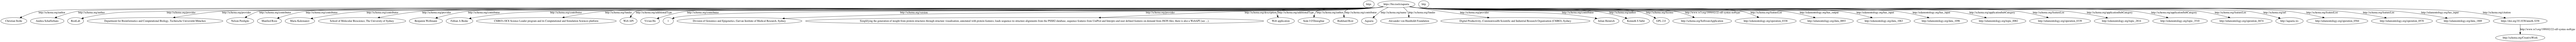

In [138]:
import networkx as nx
from nxpd import draw

print(len(g))

G = nx.DiGraph()

for s,p,o in g:
    if s:
        G.add_node(s)
    if o:
        G.add_node(o) 
    if s and o:
        if p:
            G.add_edge(s, o, label=p)

G.graph['dpi'] = 120
G.graph['layout'] = 'dot'

draw(G, show='ipynb')

# 4. Crawling all the content and producing a dump

In [164]:
%%time
g = crawl_biotools("", limit=-1)
print(len(g))
g.serialize(format='turtle', destination='test.biotools.bioschema.ttl')
print('BioSchema output produced at test.biotools.bioschema.ttl')
g.serialize(format='json-ld', auto_compact=True, destination='test.biotools.bioschema.json-ld')
print('BioSchema output produced at test.biotools.bioschema.json-ld')

14767 available BioTools entries
3 % done
7 % done
10 % done
14 % done
17 % done
20 % done
24 % done
27 % done
30 % done
34 % done
37 % done
41 % done
44 % done
47 % done
51 % done
54 % done
58 % done
61 % done
64 % done
68 % done
71 % done
74 % done
78 % done
81 % done
85 % done
88 % done
91 % done
95 % done
98 % done
195538
BioSchema output produced at test.biotools.bioschema.ttl
BioSchema output produced at test.biotools.bioschema.json-ld
CPU times: user 1min 39s, sys: 7.88 s, total: 1min 47s
Wall time: 6min 8s


In [ ]:
http://edamontology.org/EDAM.owl